In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpi
import json

from scipy.stats import pearsonr, ttest_1samp
from sklearn.linear_model import LinearRegression

from contrastive.utils.config import get_config_diff
from contrastive.utils.models_database import import_bdd

In [2]:
bdd = pd.read_csv("/neurospin/dico/agaudin/Runs/new_bdd_models.csv", index_col=0)
bdd[bdd.exclude == 'bad_learning'].groupby(['num_representation_features','backbone_name', 'foldlabel']).count()

model_path  auc  auc_std  \
num_representation_features backbone_name foldlabel                             
4                           convnet       False               7    7        7   
                                          True                2    2        2   
                            densenet      False               6    6        6   
                                          True                5    5        5   

                                                     accuracy  accuracy_std  \
num_representation_features backbone_name foldlabel                           
4                           convnet       False             7             7   
                                          True              2             2   
                            densenet      False             6             6   
                                          True              5             5   

                                                     batch_size  drop_rate  \
num_representation_features backbone_name foldlabel                          
4                           convnet       False               7          7   
                                          True                2          2   
                            densenet      False               6          6   
                                          True                5          5   

                                                     early_stopping_patience  \
num_representation_features backbone_name foldlabel                            
4                           convnet       False                            7   
                                          True                             2   
                            densenet      False                            6   
                                          True                             5   

                                                     input_size  lr  ...  \
num_representation_features backbone_name foldlabel                  ...   
4                           convnet       False               7   7  ...   
                                          True                2   2  ...   
                            densenet      False               6   6  ...   
                                          True                5   5  ...   

                                                     max_epochs  num_outputs  \
num_representation_features backbone_name foldlabel                            
4                           convnet       False               7            7   
                                          True                2            2   
                            densenet      False               6            6   
                                          True                5            5   

                                                     temperature  \
num_representation_features backbone_name foldlabel                
4                           convnet       False                7   
                                          True                 2   
                            densenet      False                6   
                                          True                 5   

                                                     temperature_initial  \
num_representation_features backbone_name foldlabel                        
4                           convnet       False                        7   
                                          True                         2   
                            densenet      False                        6   
                                          True                         5   

                                                     train_loss  val_loss  \
num_representation_features backbone_name foldlabel                         
4                           convnet       False               7         7   
                                          True                2         2   
                            d

## Resume the results

In [3]:
def exclude_conditions(diff_config, excluded_conditions):
    excluded_subdirs = []
    for cond in excluded_conditions:
        filtered_diff_config = diff_config.query(cond)
        excluded_subdirs.extend(filtered_diff_config['Unnamed: 0'].values)
    return excluded_subdirs

dir_path = "/home/jc225751/Runs/43_supervised_contrastive_ACCpatterns/Output/supervised/densenet"
diff_config = pd.read_csv(dir_path+'/config_diff.csv')
diff_config

#exclude_conditions(diff_config, excluded_conditions=["lr != 0.0004"])

,Unnamed: 0,drop_rate,early_stopping_patience,max_epochs,temperature,temperature_initial,train_val_csv_file,backbone_name
0,tau-0.1_drop-0.0,0.00,250,300,0.1,0.1,/neurospin/dico/data/deep_folding/current/data...,NaN
1,tau-0.1_drop-0.1,0.10,250,300,0.1,0.5,/neurospin/dico/data/deep_folding/current/data...,NaN
2,tau-0.5_drop-0.0,0.00,250,300,0.5,0.5,/neurospin/dico/data/deep_folding/current/data...,NaN
3,tau-0.5_drop-0.0_2,0.00,250,300,0.5,0.5,/neurospin/dico/data/deep_folding/current/data...,NaN
4,tau-0.5_drop-0.0_3,0.00,250,300,0.5,0.5,/neurospin/dico/data/deep_folding/current/data...,NaN
5,tau-0.5_drop-0.0_percentage-variable,0.00,250,300,0.5,0.5,/neurospin/dico/data/deep_folding/current/data...,NaN
6,tau-0.5_drop-0.1,0.10,250,300,0.5,0.5,/neurospin/dico/data/deep_folding/current/data...,NaN
7,tau-0.5_drop-0.15,0.15,250,300,0.5,0.5,/neurospin/dico/data/deep_folding/current/data...,NaN
8,tau-0.5_drop-0.15_percentage-variable-75,0.15,250,300,0.5,0.5,/neurospin/dico/data/deep_folding/current/data...,NaN
9,tau-0.5_drop-0.15_percentage-variable-75_2,0.15,100,301,0.5,0.5,NaN,densenet


In [12]:
def show_results(dir_path, figsize=(16,10), return_config_diff=False, excluded_conditions=[]):
    # be sure that all models are comparable
    get_config_diff(dir_path, whole_config=False)
    diff_config = pd.read_csv(dir_path+'/config_diff.csv')

    excluded_subdirs = exclude_conditions(diff_config, excluded_conditions)
    if excluded_conditions != []:
        print("Excluded subdirs :", excluded_subdirs)
        print("Excluded because of ", excluded_conditions)

    print(diff_config[~diff_config['Unnamed: 0'].isin(excluded_subdirs)])

    paths = []
    accuracy = []
    accuracy_std = []
    auc = []
    auc_std = []
    # plot all ROC curves
    for subdir in os.listdir(dir_path):
        if os.path.isdir(dir_path + '/' + subdir) and subdir not in excluded_subdirs:
            path = dir_path + '/' + subdir + '/cingulate_ACCpatterns_0_embeddings'
            with open(path+'/values.json', 'r') as file:
                values = json.load(file)
            print(subdir)
            print("AUC", values['cross_val_auc'])
            img = mpi.imread(path+'/cross_val_ROC_curves.png')
            plt.figure(figsize=figsize)
            plt.imshow(img)
            plt.show()

            # store the AUC and accuracy in a df
            paths.append(subdir)
            accuracy.append(values['cross_val_total_accuracy'][0])
            accuracy_std.append(values['cross_val_total_accuracy'][1])
            auc.append(values['cross_val_auc'][0])
            auc_std.append(values['cross_val_auc'][1])

    results_df = pd.DataFrame()
    results_df['path'] = paths
    results_df['auc'] = auc
    results_df['auc_std'] = auc_std
    results_df['accuracy'] = accuracy
    results_df['accuracy_std'] = accuracy_std


    if return_config_diff:
        return results_df, diff_config
    else:
        return results_df

   Unnamed: 0
0  23-39-22_0
1  23-39-22_1
2  23-39-22_2
3  23-39-22_3
4  23-39-22_4
23-39-22_1
AUC [0.6910872101294636, 0.0020679041509394426]


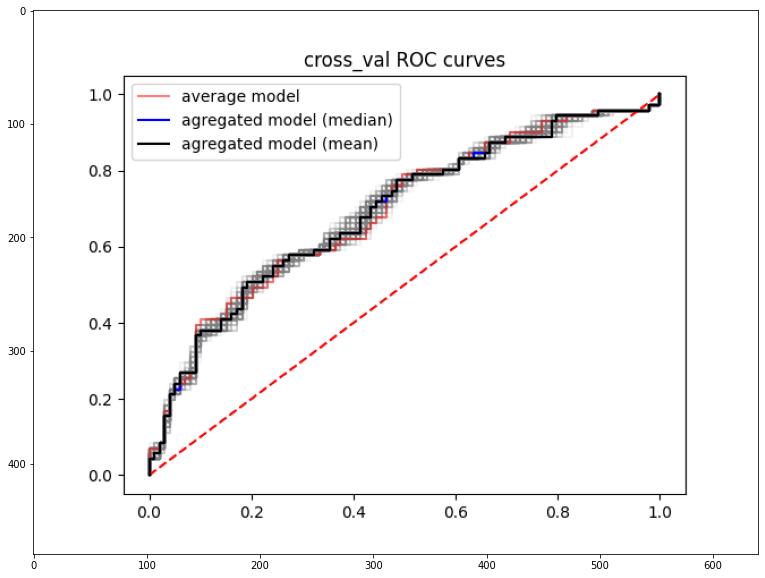

23-39-22_3
AUC [0.7520864987907241, 0.00431951438459024]


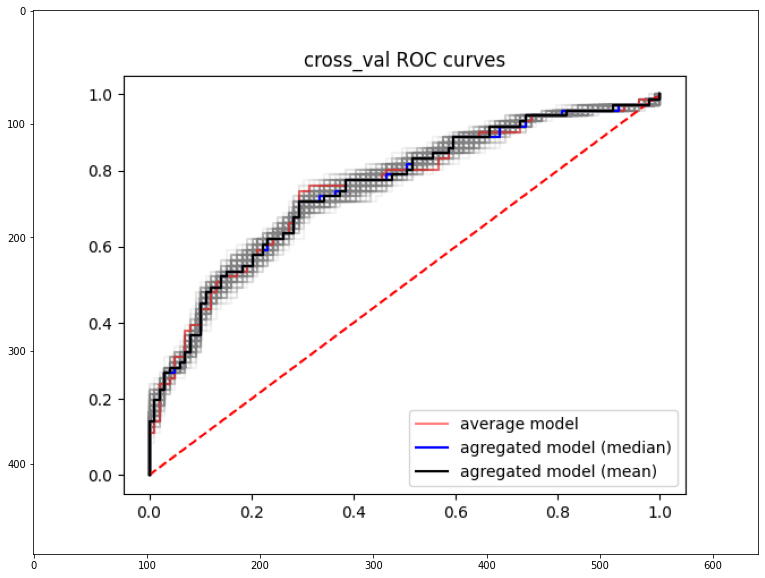

23-39-22_4
AUC [0.7841536491677337, 0.002499374047782582]


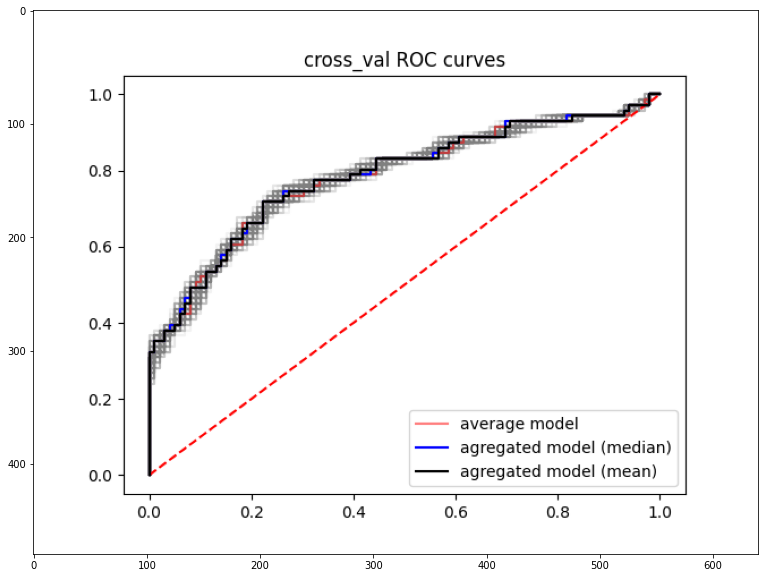

23-39-22_0
AUC [0.7019388248684023, 0.0005590745271171411]


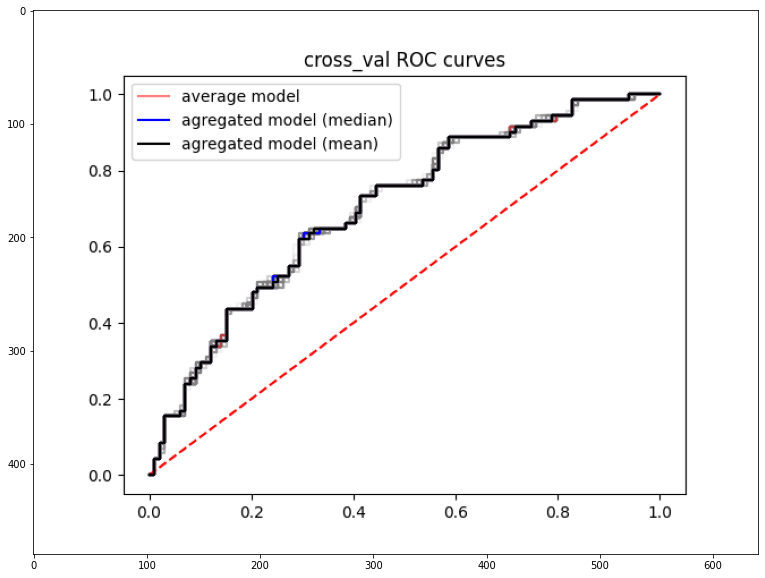

23-39-22_2
AUC [0.7566885758998435, 0.0024393683911786636]


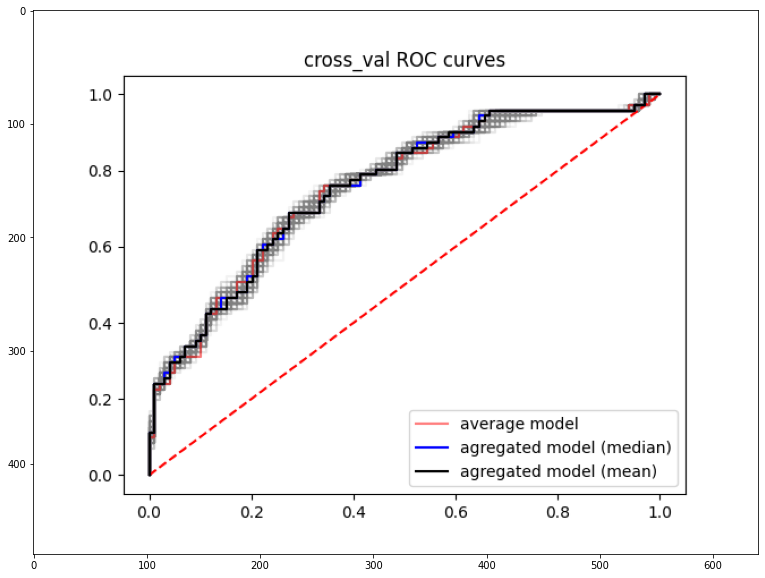

,path,auc,auc_std,accuracy,accuracy_std
0,23-39-22_1,0.691087,0.002068,0.656918,0.006234
1,23-39-22_3,0.752086,0.004320,0.703012,0.009547
2,23-39-22_4,0.784154,0.002499,0.739412,0.007501
3,23-39-22_0,0.701939,0.000559,0.641529,0.001397
4,23-39-22_2,0.756689,0.002439,0.701388,0.006646


In [40]:
excluded_conditions = []

results_df = show_results("/host//volatile/jc225751/Runs/48_aymeric/Output/SimCLR_supervised/convnet-10/linear",
excluded_conditions=excluded_conditions)

results_df

In [41]:
results_df.sort_values(ascending=False, by='auc')[['path', 'auc']]

,path,auc
2,23-39-22_4,0.784154
4,23-39-22_2,0.756689
1,23-39-22_3,0.752086
3,23-39-22_0,0.701939
0,23-39-22_1,0.691087


                                    Unnamed: 0  drop_rate  \
0                             tau-0.1_drop-0.0       0.00   
1                             tau-0.1_drop-0.1       0.10   
2                             tau-0.5_drop-0.0       0.00   
3                           tau-0.5_drop-0.0_2       0.00   
4                           tau-0.5_drop-0.0_3       0.00   
5         tau-0.5_drop-0.0_percentage-variable       0.00   
6                             tau-0.5_drop-0.1       0.10   
7                            tau-0.5_drop-0.15       0.15   
8     tau-0.5_drop-0.15_percentage-variable-75       0.15   
9   tau-0.5_drop-0.15_percentage-variable-75_2       0.15   
10                          tau-0.5_drop-0.1_2       0.10   
11            tau-0.5_drop-0.2_drop-output-0.0       0.20   
12            tau-0.5_drop-0.2_drop-output-0.1       0.20   

    early_stopping_patience  max_epochs  temperature  temperature_initial  \
0                       250         300          0.1                

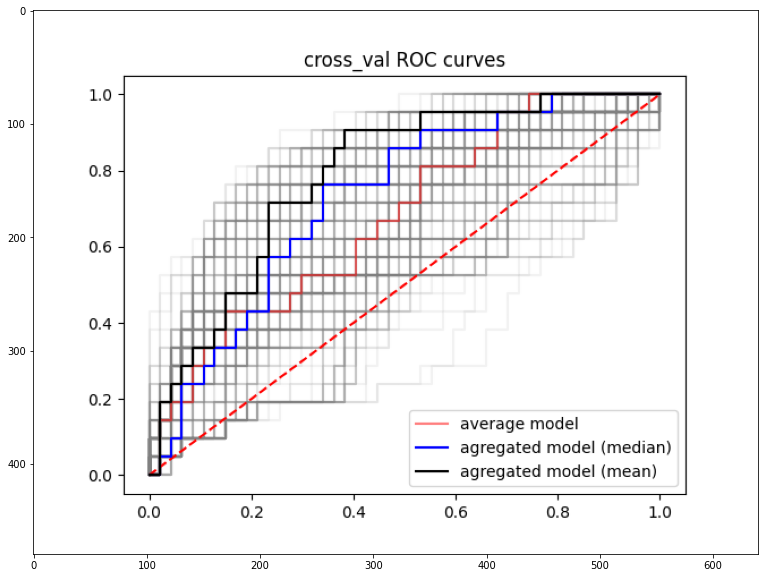

tau-0.1_drop-0.1
AUC [0.5578399189463018, 0.06382768250498178]


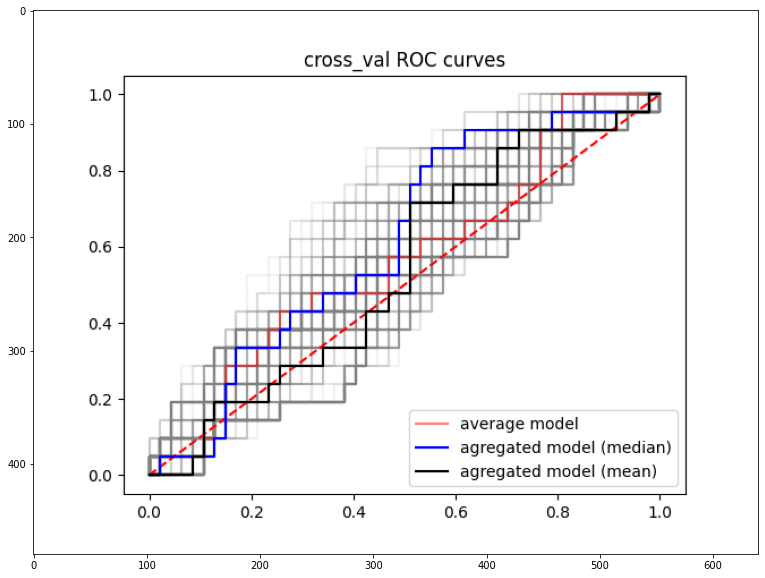

tau-0.5_drop-0.0_3
AUC [0.7904275582573455, 0.08015607895434278]


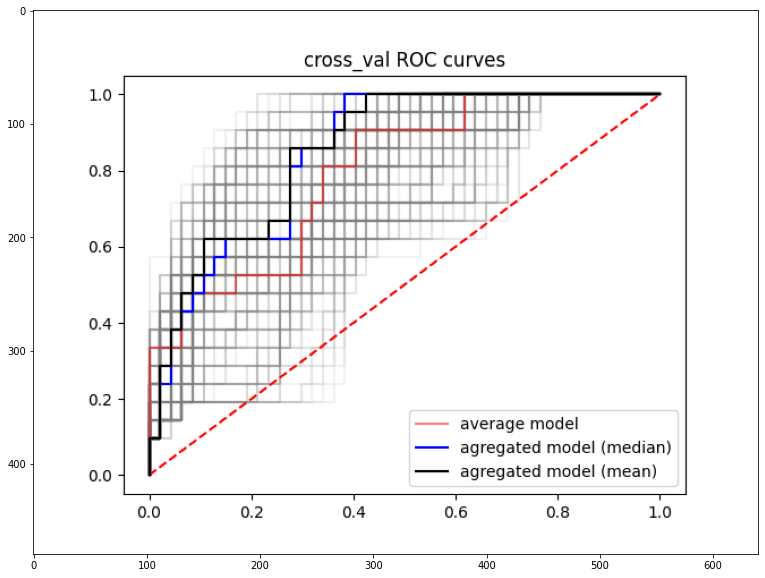

tau-0.5_drop-0.1
AUC [0.6520567375886525, 0.10145402908193465]


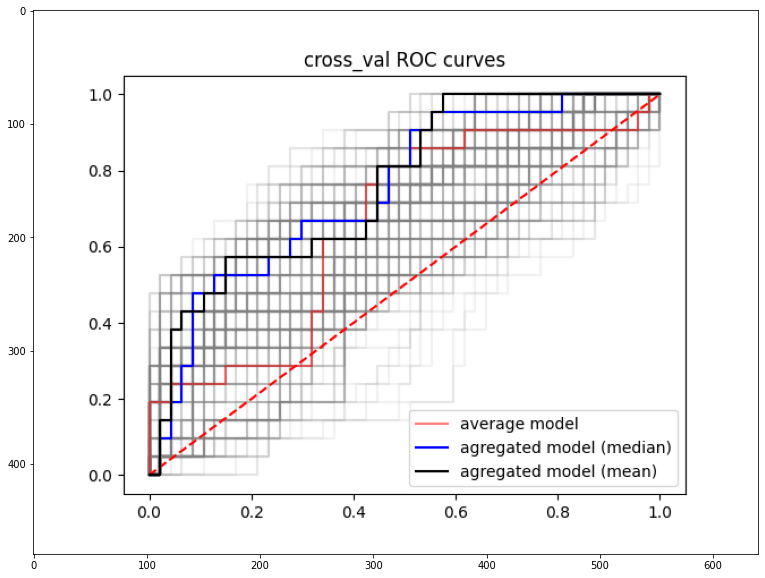

tau-0.5_drop-0.2_drop-output-0.1
AUC [0.6923606889564337, 0.07886553978647642]


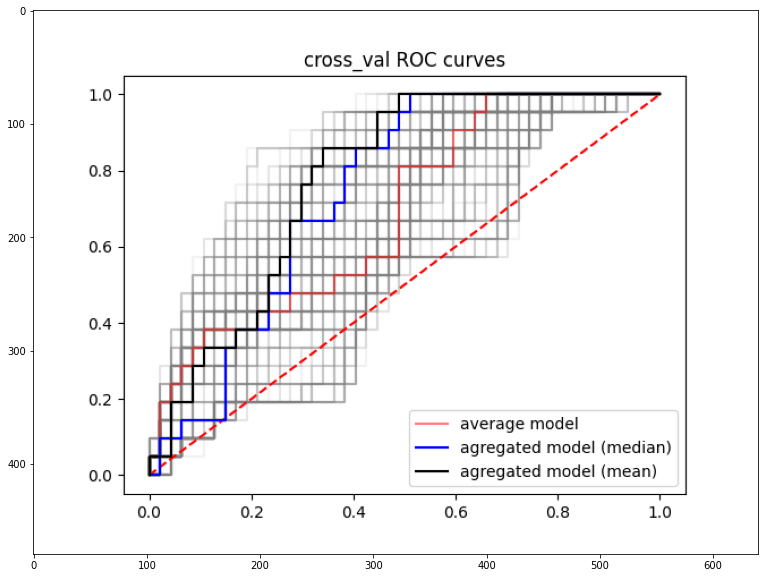

tau-0.5_drop-0.2_drop-output-0.0
AUC [0.7259777102330294, 0.08000158338515732]


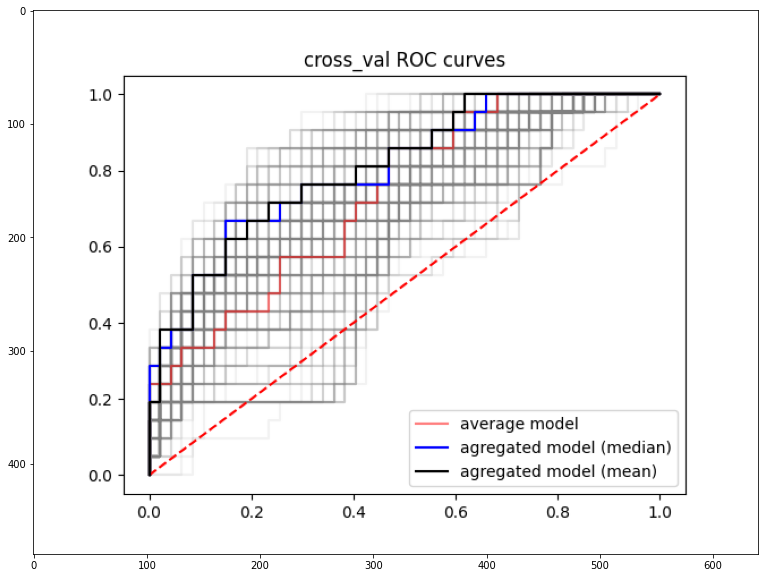

FileNotFoundError: [Errno 2] No such file or directory: '/home/jc225751/Runs/43_supervised_contrastive_ACCpatterns/Output/supervised/densenet/tau-0.5_drop-0.15_percentage-variable-75_2/cingulate_ACCpatterns_embeddings/values.json'

In [11]:
excluded_conditions = []

results_df = show_results("/home/jc225751/Runs/43_supervised_contrastive_ACCpatterns/Output/supervised/densenet",
excluded_conditions=excluded_conditions)

results_df

In [12]:
results_df.sort_values(ascending=False, by='auc')[['path', 'auc']]

,path,auc
0,without-forcing_foldabel_1,0.541490
1,without-forcing_foldabel_2,0.514956


/volatile/jc225751/Runs/43_supervised_contrastive_ACCpatterns/Program/2022_jchavas_cingulate_inhibitory_control/contrastive/utils/config.py:123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  global_df = pd.concat([global_df, config_df], axis=0)


                                          Unnamed: 0 backbone_name  drop_rate  \
0            tau-0.5_drop-0.0_percentage-variable-75       convnet       0.00   
1          tau-0.5_drop-0.15_cutout_backbone-convnet           NaN       0.15   
2  tau-0.5_drop-0.15_percentage-variable-75_backb...           NaN       0.15   
3  tau-0.5_drop-0.15_percentage-variable-75_backb...       convnet       0.15   
4  tau-0.5_drop-0.25_percentage-variable-75_backb...           NaN       0.25   
5  tau-0.5_drop-0.2_percentage-variable-75_backbo...           NaN       0.15   
6  tau-0.5_drop-0.3_percentage-variable-75_backbo...           NaN       0.30   

   early_stopping_patience  foldlabel  max_angle      patch_size  \
0                      100       True          6             NaN   
1                      250      False         10  [1, 9, 22, 21]   
2                      250       True          6             NaN   
3                      100       True          6             NaN   
4          

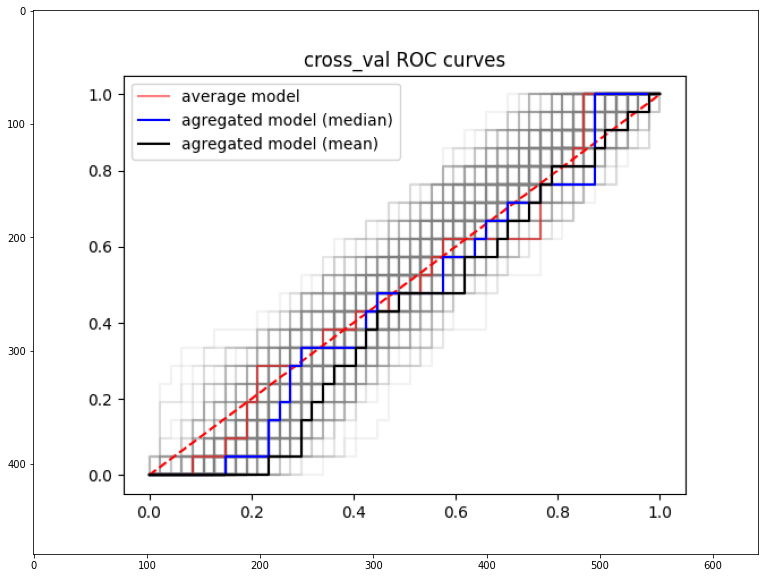

tau-0.5_drop-0.0_percentage-variable-75
AUC [0.5627720364741642, 0.09388947962022412]


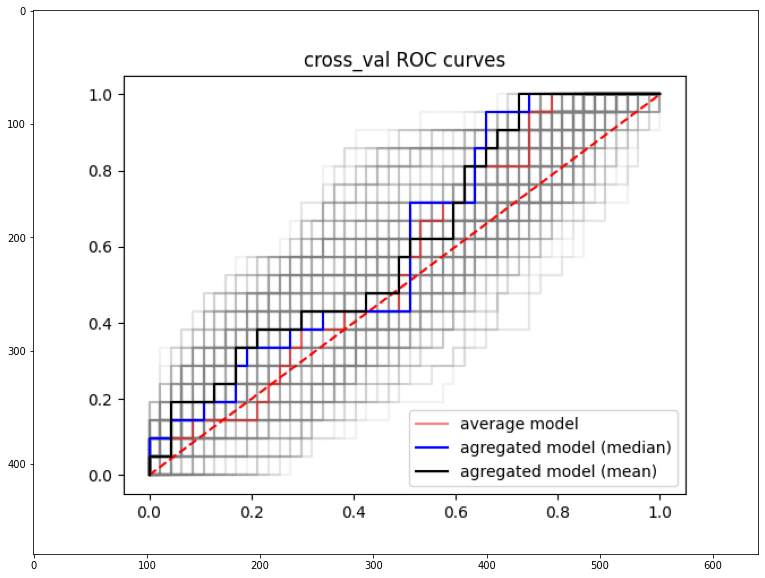

tau-0.5_drop-0.15_cutout_backbone-convnet
AUC [0.5149138804457952, 0.08362887145886067]


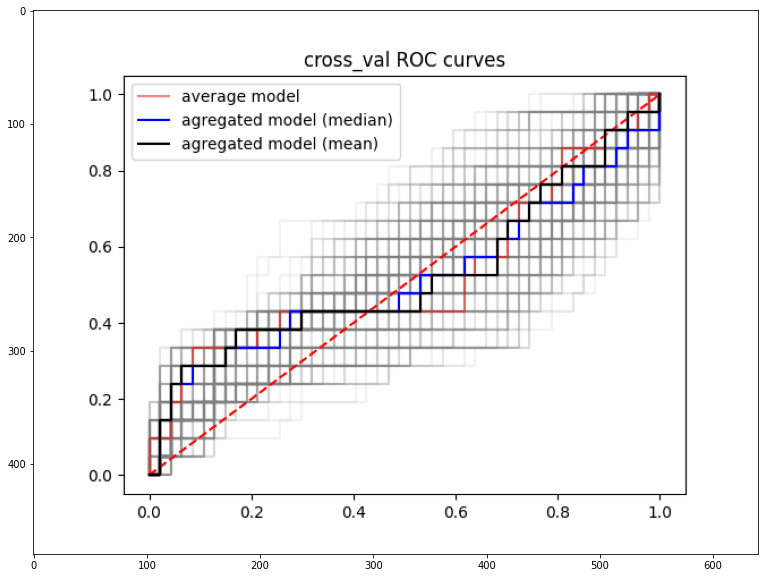

tau-0.5_drop-0.25_percentage-variable-75_backbone-convnet
AUC [0.36738804457953395, 0.10796514149720135]


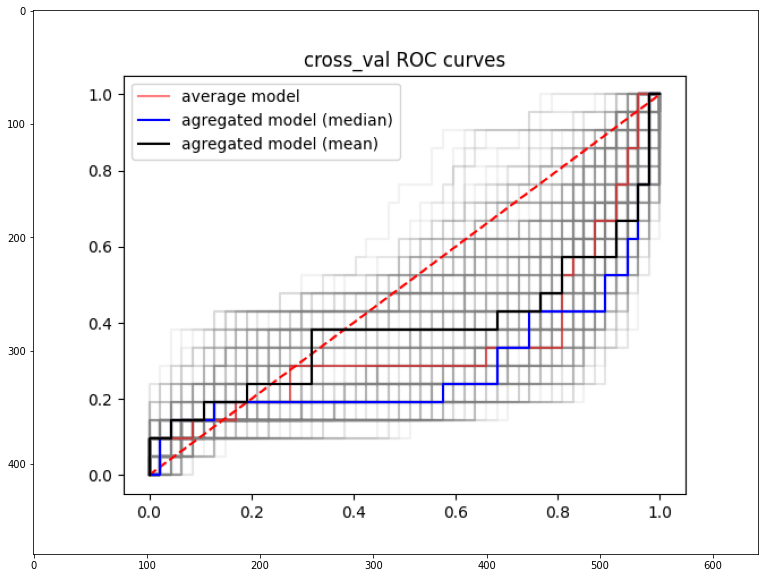

tau-0.5_drop-0.15_percentage-variable-75_backbone-convnet_2
AUC [0.481531914893617, 0.04646467770058261]


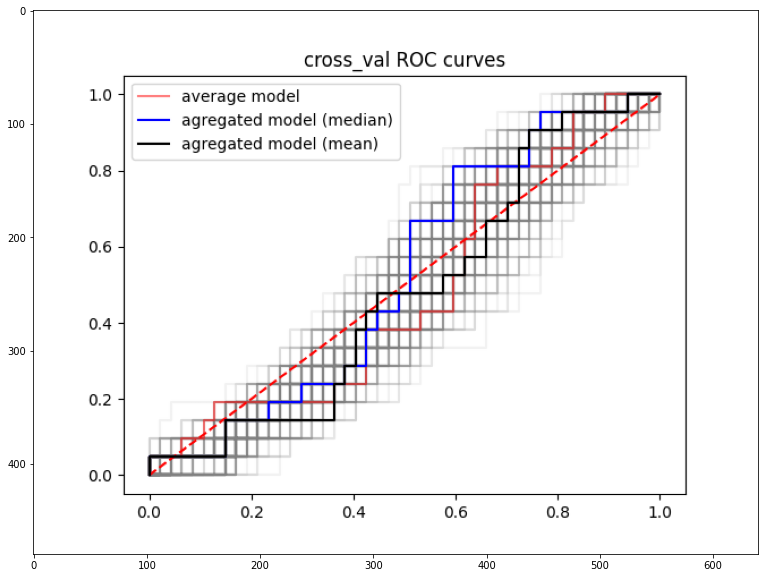

tau-0.5_drop-0.2_percentage-variable-75_backbone-convnet
AUC [0.508838905775076, 0.05888613419413187]


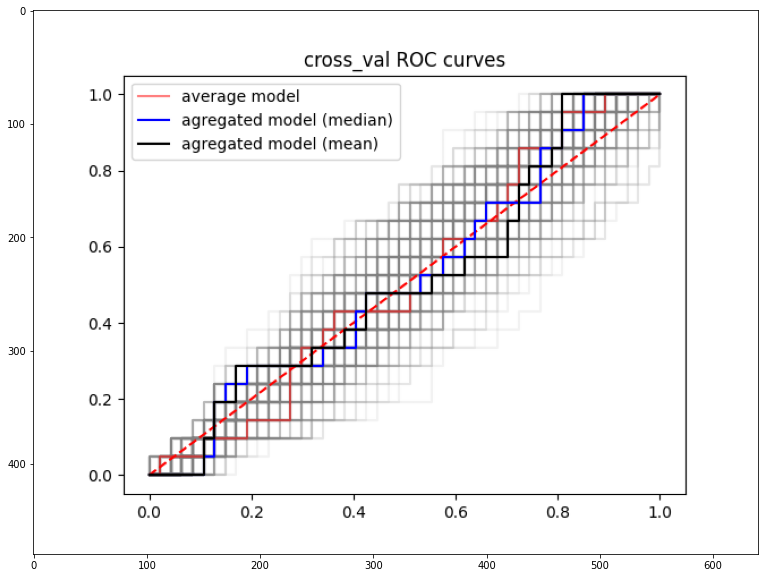

tau-0.5_drop-0.15_percentage-variable-75_backbone-convnet
AUC [0.5013171225937183, 0.061914561197816353]


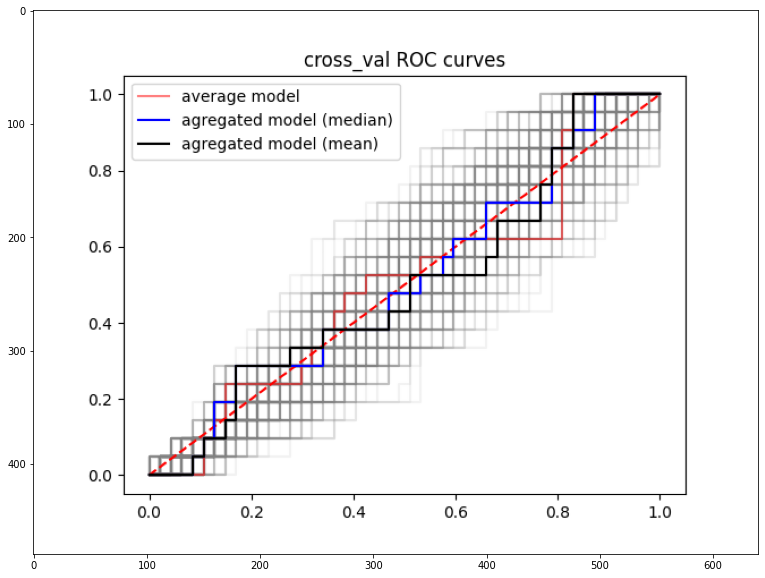

path       auc   auc_std  \
0  tau-0.5_drop-0.3_percentage-variable-75_backbo...  0.494890  0.061100   
1            tau-0.5_drop-0.0_percentage-variable-75  0.562772  0.093889   
2          tau-0.5_drop-0.15_cutout_backbone-convnet  0.514914  0.083629   
3  tau-0.5_drop-0.25_percentage-variable-75_backb...  0.367388  0.107965   
4  tau-0.5_drop-0.15_percentage-variable-75_backb...  0.481532  0.046465   
5  tau-0.5_drop-0.2_percentage-variable-75_backbo...  0.508839  0.058886   
6  tau-0.5_drop-0.15_percentage-variable-75_backb...  0.501317  0.061915   

   accuracy  accuracy_std  
0  0.684294      0.014595  
1  0.640824      0.077700  
2  0.691529      0.030021  
3  0.671471      0.029501  
4  0.613353      0.054943  
5  0.617941      0.040721  
6  0.614294      0.038348

In [19]:
excluded_conditions = []

results_df = show_results("/home/jc225751/Runs/43_supervised_contrastive_ACCpatterns/Output/supervised/convnet",
excluded_conditions=excluded_conditions)

results_df

In [20]:
results_df.sort_values(ascending=False, by='auc')[['path', 'auc']]

,path,auc
9,pointnet_sigmoid_no,0.633446
0,11-05-29,0.611789
2,convnet_sigmoid_fold,0.605882
5,12-18-43,0.556314
7,12-19-16,0.541111
8,densenet_sigmoid_no,0.525296
4,tau-0.5_drop-0.15_percentage-variable-75_backb...,0.481532
3,tau-0.5_drop-0.25_percentage-variable-75_backb...,0.367388


In [ ]:
excluded_conditions = []

results_df = show_results("/neurospin/dico/agaudin/Runs/03_monkeys/Output/analysis_folders/supervised/acc/aymeric",
excluded_conditions=excluded_conditions)

results_df

In [22]:
results_df.sort_values(ascending=False, by='auc')[['path', 'auc']]

path       auc
2                 lr=0.0008  0.564815
1  non_supervised_lr=0.0008  0.555703
0                 lr=0.0004  0.532388

In [ ]:
# convnet exploration
excluded_conditions = []

results_df = show_results("/neurospin/dico/agaudin/Runs/03_monkeys/Output/convnet_exploration",
excluded_conditions=excluded_conditions)

results_df

In [8]:
results_df.sort_values(ascending=False, by='auc')[['path', 'auc']]

,path,auc
11,base1,0.673959
2,T_1,0.655674
10,drop_rate_0,0.654164
9,base2,0.648114
14,base3,0.644770
5,batch_size_64,0.636690
8,T_0.01,0.626335
4,T_0.5,0.624267
7,batch_size_4,0.617623
3,drop_rate_0.3,0.609882


In [11]:
# directories are supposed to have a certain structure and name patterns
def get_results_table(dir_path, model_types=['convnet', 'densenet2'], verbose=False):
    results = {k: {} for k in model_types}

    for model_type in os.listdir(dir_path):
        if model_type in model_types:
            if verbose:
                print(model_type)
            path = os.path.join(dir_path, model_type)
            for params in os.listdir(path):
                params_path = os.path.join(path, params)
                if os.path.isdir(params_path):
                    if verbose:
                        print(params)
                    
                    n_models = 0

                    if model_type == 'pca':
                        results[model_type]['foldlabel_'+params] = 0
                        results[model_type]['no_foldlabel_'+params] = 0
                    else:    
                        results[model_type][params] = 0
                    
                    for model in os.listdir(params_path):
                        model_path = os.path.join(params_path, model)
                        # start a model name by & to filter it out of the performance analysis
                        if os.path.isdir(model_path) and model[0] != '&':
                            if verbose:
                                print(model)

                            n_models += 1

                            if model_type == 'pca':
                                values = os.path.join(params_path, model, 'values.json')
                                with open(values, 'r') as file:
                                    values = json.load(file)
                                results[model_type]['foldlabel_'+params] += values['cross_val_auc'][0]
                                results[model_type]['no_foldlabel_'+params] += values['cross_val_auc'][0]
                            else:
                                values = os.path.join(params_path, model, 'cingulate_ACCpatterns_embeddings/values.json')
                                with open(values, 'r') as file:
                                    values = json.load(file)
                                results[model_type][params] += values['cross_val_auc'][0]
                    
                    if model_type == 'pca':
                        results[model_type]['foldlabel_'+params] = results[model_type]['foldlabel_'+params]/n_models
                        results[model_type]['no_foldlabel_'+params] = results[model_type]['no_foldlabel_'+params]/n_models
                    else:
                        results[model_type][params] = results[model_type][params]/n_models
    
    results_df = pd.DataFrame(results)
    results_df.sort_index(inplace=True)
    return results_df

In [12]:
dir_path = "/neurospin/dico/agaudin/Runs/03_monkeys/Output/analysis_folders"
results_df = get_results_table(dir_path, model_types=['convnet', 'densenet2', 'pca'])

results_df.to_csv("/neurospin/dico/agaudin/Runs/03_monkeys/Output/analysis_folders/performance_comparison_5000.csv")

results_df

,convnet,densenet2,pca
foldlabel_30,0.613729,0.658608,0.593625
foldlabel_4,0.589703,0.574395,0.538784
no_foldlabel_30,0.649748,0.575910,0.593625
no_foldlabel_4,0.514435,0.488433,0.538784


## Use the database

In [80]:
bdd = import_bdd(verbose=True)
bdd

path /neurospin/dico/agaudin/Runs/new_bdd_models.csv
19 have been removed for bad learning


,model_path,auc,auc_std,accuracy,accuracy_std,backbone_name,batch_size,drop_rate,early_stopping_patience,foldlabel,...,num_outputs,num_representation_features,temperature,temperature_initial,train_loss,val_loss,exclude,0.1_quantile,dataset_name,git_branch
100,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.752147,0.003479,0.705150,0.009098,convnet,16,0.05,100,True,...,4,4,0.1,0.1,1.240257,1.669160,False,0.078811,cingulate_HCP_half_1,Run_03_aymeric
120,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.743639,0.004698,0.703261,0.006989,convnet,16,0.05,100,True,...,4,4,0.1,0.1,1.251985,1.929024,False,0.594088,cingulate_HCP_half_1,Run_03_aymeric
119,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.729348,0.002100,0.669314,0.005821,convnet,16,0.05,100,True,...,4,4,0.1,0.1,1.374010,1.463949,False,0.199899,cingulate_HCP_half_1,Run_03_aymeric
129,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.721823,0.048261,0.631249,0.058619,densenet,16,0.05,100,True,...,30,30,0.1,0.1,0.515141,1.306467,False,0.640115,cingulate_HCP_half_1,Run_03_aymeric
111,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.717813,0.013023,0.691284,0.013834,convnet,16,0.05,100,True,...,4,4,0.1,0.1,1.954553,2.959328,False,0.652514,cingulate_HCP_half_1,Run_03_aymeric
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.482994,0.034076,0.512551,0.030729,densenet,16,0.15,100,False,...,4,4,0.1,0.1,3.753164,3.651408,False,-0.688383,cingulate_HCP_half_1,Run_03_aymeric
145,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.478818,0.022703,0.576880,0.003572,pointnet,16,0.05,100,True,...,4,4,0.5,0.5,5.256860,5.389712,False,0.129245,cingulate_HCP_half_1,pointnet
19,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.473885,0.042166,0.510393,0.050783,convnet,16,0.15,100,False,...,4,4,0.1,0.1,8.022524,6.433455,False,0.943119,cingulate_HCP_half_1,Run_03_aymeric
38,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.466274,0.034258,0.547683,0.020623,densenet,16,0.15,100,False,...,4,4,0.1,0.1,3.534628,3.446562,False,-0.106718,cingulate_HCP_half_1,Run_03_aymeric


In [98]:
filtered_bdd = bdd[(bdd.backbone_name == 'convnet') & (bdd.foldlabel == True) & (bdd.num_representation_features == 30)]
filtered_bdd

,model_path,auc,auc_std,accuracy,accuracy_std,backbone_name,batch_size,drop_rate,early_stopping_patience,foldlabel,...,num_outputs,num_representation_features,temperature,temperature_initial,train_loss,val_loss,exclude,0.1_quantile,dataset_name,git_branch
2,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.659754,0.048348,0.617584,0.042720,convnet,16,0.15,250,True,...,30,30,0.1,0.1,0.416473,0.440377,False,-0.051465,cingulate_HCP_half_1,Run_03_aymeric
71,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.646287,0.045746,0.617396,0.035959,convnet,16,0.05,100,True,...,30,30,0.5,0.5,3.754291,3.626619,False,-0.318051,cingulate_HCP_half_1,Run_03_aymeric
70,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.637802,0.045663,0.604117,0.038849,convnet,16,0.05,100,True,...,30,30,0.5,0.5,3.659372,3.585553,False,-0.228570,cingulate_HCP_half_1,Run_03_aymeric
69,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.611436,0.044218,0.588211,0.034569,convnet,16,0.05,100,True,...,30,30,0.1,0.1,0.218518,0.478270,False,-0.275497,cingulate_HCP_half_1,Run_03_aymeric
4,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.606865,0.044687,0.588305,0.037069,convnet,16,0.15,250,True,...,30,30,0.1,0.1,0.330082,0.690635,False,-0.194344,cingulate_HCP_half_1,Run_03_aymeric
3,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.605214,0.042651,0.588129,0.037000,convnet,16,0.15,100,True,...,30,30,0.1,0.1,0.392093,0.608668,False,-0.354155,cingulate_HCP_half_1,Run_03_aymeric
1,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.600870,0.040834,0.578182,0.038861,convnet,16,0.15,100,True,...,30,30,0.1,0.1,0.376334,0.615989,False,-0.214874,cingulate_HCP_half_1,Run_03_aymeric
0,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.595940,0.045925,0.575977,0.035288,convnet,16,0.15,100,True,...,30,30,0.1,0.1,0.349243,0.515141,False,-0.149932,cingulate_HCP_half_1,Run_03_aymeric
72,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.593398,0.056054,0.585232,0.040975,convnet,16,0.05,100,True,...,30,30,0.5,0.5,3.714237,3.622833,False,-0.285862,cingulate_HCP_half_1,Run_03_aymeric
68,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.590271,0.041144,0.577326,0.034839,convnet,16,0.05,100,True,...,30,30,0.1,0.1,0.178311,0.599187,False,-0.219919,cingulate_HCP_half_1,Run_03_aymeric


In [70]:
bdd.iloc[:10,:]

,model_path,auc,auc_std,accuracy,accuracy_std,backbone_name,batch_size,drop_rate,early_stopping_patience,foldlabel,...,num_outputs,num_representation_features,temperature,temperature_initial,train_loss,val_loss,exclude,0.1_quantile,dataset_name,git_branch
100,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.752147,0.003479,0.705150,0.009098,convnet,16,0.05,100,True,...,4,4,0.1,0.1,1.240257,1.669160,False,0.078811,cingulate_HCP_half_1,Run_03_aymeric
120,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.743639,0.004698,0.703261,0.006989,convnet,16,0.05,100,True,...,4,4,0.1,0.1,1.251985,1.929024,False,0.594088,cingulate_HCP_half_1,Run_03_aymeric
119,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.729348,0.002100,0.669314,0.005821,convnet,16,0.05,100,True,...,4,4,0.1,0.1,1.374010,1.463949,False,0.199899,cingulate_HCP_half_1,Run_03_aymeric
111,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.717813,0.013023,0.691284,0.013834,convnet,16,0.05,100,True,...,4,4,0.1,0.1,1.954553,2.959328,False,0.652514,cingulate_HCP_half_1,Run_03_aymeric
150,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.694205,0.008692,0.669267,0.009264,pointnet,16,0.15,100,True,...,30,30,0.5,0.5,4.367986,4.052493,False,-0.430873,cingulate_HCP_half_1,pointnet
75,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.693590,0.051831,0.619449,0.052646,densenet,16,0.05,100,True,...,30,30,0.1,0.1,0.762840,1.369004,False,0.757828,cingulate_HCP_half_1,Run_03_aymeric
25,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.692153,0.049598,0.629595,0.054254,densenet,16,0.15,100,True,...,30,30,0.1,0.1,1.032371,2.509686,False,0.683913,cingulate_HCP_half_1,Run_03_aymeric
125,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.678702,0.006920,0.668692,0.007873,pointnet,16,0.05,100,True,...,30,30,0.1,0.1,1.336895,2.419318,False,-0.361733,cingulate_HCP_half_1,pointnet
12,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.678640,0.044072,0.634545,0.037935,convnet,16,0.15,100,False,...,30,30,0.1,0.1,0.263586,0.195343,False,-0.301107,cingulate_HCP_half_1,Run_03_aymeric
153,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.677713,0.000947,0.647801,0.002533,pointnet,16,0.00,100,True,...,30,30,0.1,0.1,0.957840,1.012913,False,-0.313915,cingulate_HCP_half_1,pointnet


In [3]:
columns_of_interest = ['backbone_name', 'batch_size', 'drop_rate', 'foldlabel', 'lr', 'num_outputs', 'num_representation_features',
'temperature', 'temperature_initial', 'dataset_name']

In [4]:
interesting_columns = ["model_path", 'auc', 'auc_std', 'backbone_name', 'batch_size', 'dataset_name', 'drop_rate', 'foldlabel',
                       'num_representation_features', 'temperature']
bdd[interesting_columns].iloc[:10,:]

,model_path,auc,auc_std,backbone_name,batch_size,dataset_name,drop_rate,foldlabel,num_representation_features,temperature
116,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.694205,0.008692,pointnet,16,cingulate_HCP_half_1,0.15,True,30,0.5
75,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.693590,0.051831,densenet,16,cingulate_HCP_half_1,0.05,True,30,0.1
25,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.692153,0.049598,densenet,16,cingulate_HCP_half_1,0.15,True,30,0.1
91,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.678702,0.006920,pointnet,16,cingulate_HCP_half_1,0.05,True,30,0.1
12,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.678640,0.044072,convnet,16,cingulate_HCP_half_1,0.15,False,30,0.1
119,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.677713,0.000947,pointnet,16,cingulate_HCP_half_1,0.00,True,30,0.1
85,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.676890,0.006477,pointnet,16,cingulate_HCP_half_1,0.05,True,30,0.1
113,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.674897,0.015476,pointnet,16,cingulate_HCP_half_1,0.15,True,30,0.1
50,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.673959,0.041645,convnet,16,cingulate_HCP_half_1,0.15,False,30,0.1
105,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.672935,0.013104,pointnet,16,cingulate_HCP_full,0.05,True,4,0.5


In [53]:
pointnets = bdd[bdd.backbone_name == 'pointnet']

,model_path,auc,auc_std,accuracy,accuracy_std,backbone_name,batch_size,drop_rate,early_stopping_patience,foldlabel,...,num_outputs,num_representation_features,temperature,temperature_initial,train_loss,val_loss,exclude,0.1_quantile,dataset_name,git_branch
116,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.694205,0.008692,0.669267,0.009264,pointnet,16,0.15,100,True,...,30,30,0.5,0.5,4.367986,4.052493,False,-0.430873,cingulate_HCP_half_1,pointnet
105,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.672935,0.013104,0.594358,0.004636,pointnet,16,0.05,100,True,...,4,4,0.5,0.5,4.635521,4.643420,False,-0.759075,cingulate_HCP_full,pointnet
98,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.661953,0.003243,0.658041,0.003178,pointnet,16,0.05,100,True,...,4,4,0.5,0.5,4.674354,4.030462,False,-0.722002,cingulate_HCP_half_1,pointnet
104,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.659615,0.005971,0.631543,0.005587,pointnet,16,0.05,100,True,...,4,4,0.5,0.5,4.577002,4.646541,False,-0.736746,cingulate_HCP_full,pointnet
102,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.651624,0.005031,0.659390,0.004526,pointnet,16,0.05,100,True,...,4,4,0.5,0.5,4.649200,4.309664,False,-0.905572,cingulate_HCP_half_1,pointnet
99,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.627749,0.004010,0.636903,0.004372,pointnet,16,0.05,100,True,...,4,4,0.5,0.5,5.068661,4.258512,False,-0.451378,cingulate_HCP_half_1,pointnet
117,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.606891,0.013846,0.607930,0.012928,pointnet,16,0.15,100,True,...,30,30,0.5,0.5,4.366843,4.134495,False,-0.522619,cingulate_HCP_half_1,pointnet
107,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.583615,0.003723,0.602346,0.002944,pointnet,16,0.05,100,True,...,4,4,0.5,0.5,4.667727,4.613417,False,-0.769397,cingulate_HCP_full,pointnet
101,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.536983,0.005141,0.544880,0.003870,pointnet,16,0.05,100,True,...,4,4,0.5,0.5,4.673968,4.301939,False,-0.775752,cingulate_HCP_half_1,pointnet
106,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.517515,0.009011,0.562968,0.002984,pointnet,16,0.05,100,True,...,4,4,0.5,0.5,4.544183,4.529235,False,-0.614247,cingulate_HCP_full,pointnet


In [51]:
pointnets.groupby(['foldlabel', 'num_representation_features','temperature']).count()

model_path  auc  auc_std  \
foldlabel num_representation_features temperature                             
False     4                           0.10                  2    2        2   
          12                          0.10                  1    1        1   
          30                          0.10                  8    8        8   
True      4                           0.10                  2    2        2   
                                      0.50                 10   10       10   
          30                          0.01                  1    1        1   
                                      0.10                 18   18       18   
                                      0.50                  2    2        2   

                                                   accuracy  accuracy_std  \
foldlabel num_representation_features temperature                           
False     4                           0.10                2             2   
          12                          0.10                1             1   
          30                          0.10                8             8   
True      4                           0.10                2             2   
                                      0.50               10            10   
          30                          0.01                1             1   
                                      0.10               18            18   
                                      0.50                2             2   

                                                   backbone_name  batch_size  \
foldlabel num_representation_features temperature                              
False     4                           0.10                     2           2   
          12                          0.10                     1           1   
          30                          0.10                     8           8   
True      4                           0.10                     2           2   
                                      0.50                    10          10   
          30                          0.01                     1           1   
                                      0.10                    18          18   
                                      0.50                     2           2   

                                                   drop_rate  \
foldlabel num_representation_features temperature              
False     4                           0.10                 2   
          12                          0.10                 1   
          30                          0.10                 8   
True      4                           0.10                 2   
                                      0.50                10   
          30                          0.01                 1   
                                      0.10                18   
                                      0.50                 2   

                                                   early_stopping_patience  \
foldlabel num_representation_features temperature                            
False     4                           0.10                               2   
          12                          0.10                               1   
          30                          0.10                               8   
True      4                           0.10                               2   
                                      0.50                              10   
          30                          0.01                               1   
                                      0.10                              18   
                                      0.50                               2   

                                                   input_size  ...  max_angle  \
foldlabel num_representation_features temperature              ...              
False     4                           0.10                  2  ...          2   
          12           

### Performance histogram

In [81]:
backbones = ['convnet', 'densenet', 'pointnet']
foldlabels = [False, True]
dimensions = [4, 30]

n_bb = len(backbones)
n_fold = len(foldlabels)
n_dims = len(dimensions)

colors = ['r', 'b', 'g']

pca4 = [0.539, 0.062]
pca30 = [0.595, 0.043]

clean_bdd = bdd[(bdd.temperature == 0.1) & (bdd.drop_rate == 0.05)]

In [82]:
def performance_histogram(bdd, main, x, y, filters, colors=['r', 'b', 'g'], extended=True):
    n_x = len(x)
    n_y = len(y)
    
    plt.figure()
    bins = np.arange(0.45, 0.71, step=0.01)

    for i,element in enumerate(main):
        filtered_bdd = bdd[(bdd[filters[0]] == element) & ~(bdd.model_path.str.contains('unfinished'))]
        print(f"{element}, N = {filtered_bdd.shape[0]}, mean performance: {filtered_bdd.auc.mean()}")
        plt.hist(filtered_bdd['auc'].values, bins, color=colors[i], alpha=0.6)
        plt.xlabel('auc')
    
    if main == dimensions:
        ax = plt.gca()
        y_min, y_max = ax.get_ylim()
        plt.vlines(pca4[0], ymin=y_min, ymax=y_max, colors='blue')
        plt.vlines(pca30[0], ymin=y_min, ymax=y_max, colors='red')

    
    if main == foldlabels:
        plt.legend(["no_foldlabel", "foldlabel"])
    elif main == dimensions:
        plt.legend(['pca (dim=4)', 'pca (dim=30)'] + main)
    plt.show()

    if extended:
        plt.figure(figsize=(n_y*6.4, n_x*4.8))

        for j in range(n_x):
            for k in range(n_y):
                pre_filtered_bdd = bdd[(bdd[filters[1]] == x[j]) & (bdd[filters[2]] == y[k])]
                print(x[j], y[k])
                plt.subplot(n_x, n_y, k + n_y*j + 1)
                for i,element in enumerate(main):
                    filtered_bdd = pre_filtered_bdd[(pre_filtered_bdd[filters[0]] == element) & ~(pre_filtered_bdd.model_path.str.contains('unfinished'))]
                    print(f"{element}, N = {filtered_bdd.shape[0]}, mean performance: {filtered_bdd.auc.mean()}")
                    plt.hist(filtered_bdd['auc'].values, bins, color=colors[i], alpha=0.6)
                    plt.xlabel('auc')
                    plt.title(str(x[j])+' '+ str(y[k]))
                print()
                plt.legend(main)
        plt.show()

convnet, N = 12, mean performance: 0.6419677570971988
densenet, N = 20, mean performance: 0.5970185772701635
pointnet, N = 27, mean performance: 0.6213266173675086


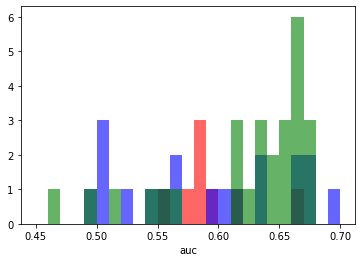

In [83]:
performance_histogram(clean_bdd, backbones, foldlabels, dimensions, filters=['backbone_name', 'foldlabel', 'num_representation_features'],
                      extended=False)

False, N = 23, mean performance: 0.570762359302582
True, N = 36, mean performance: 0.64700747320925


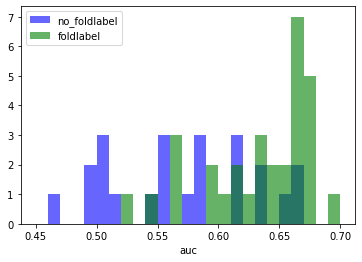

In [84]:
performance_histogram(clean_bdd, foldlabels, dimensions, backbones, filters=['foldlabel', 'num_representation_features', 'backbone_name'],
                      colors=['b', 'g'], extended=False)

4, N = 31, mean performance: 0.591061404945145
30, N = 27, mean performance: 0.6457728113053831


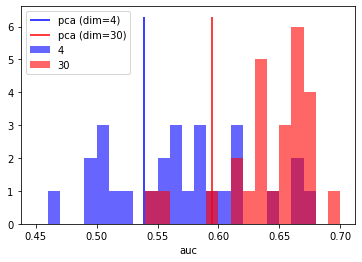

In [85]:
performance_histogram(clean_bdd, dimensions, foldlabels, backbones, filters=['num_representation_features', 'foldlabel', 'backbone_name'],
                      colors=['b', 'r'], extended=False)

#### Results tables

In [86]:
def significance_over_pca(backbone, foldlabel, dim):
    filtered_df = clean_bdd[(clean_bdd.backbone_name == backbone) & (clean_bdd.foldlabel == foldlabel) & (clean_bdd.num_representation_features == dim)]
    aucs = filtered_df.auc

    if dim == 4:
        pca = pca4
    elif dim == 30:
        pca = pca30
    else:
        raise ValueError('Not a dimension the PCA is evaluated for')
    
    return ttest_1samp(aucs, pca[0])

In [87]:
backbones = ['convnet', 'densenet', 'pointnet']
dims = [4, 30]
foldlabels = [False, True]

idx = ['no foldlabel 4', 'foldlabel 4', 'no foldlabel 30', 'foldlabel 30']

df = pd.DataFrame(np.zeros((4,3)), index=idx, columns=backbones)
std_df = pd.DataFrame(np.zeros((4,3)), index=idx, columns=backbones)
count_df = pd.DataFrame(np.zeros((4,3)), index=idx, columns=backbones, dtype=int)
p_values_df = pd.DataFrame(np.zeros((4,3)), index=idx, columns=backbones)

for backbone in backbones:
    i = 0
    for dim in dims:
        for foldlabel in foldlabels:
            filtered_bdd = clean_bdd[(clean_bdd.backbone_name == backbone) & (clean_bdd.foldlabel == foldlabel) & (clean_bdd.num_representation_features == dim)]
            df[backbone][i] = filtered_bdd.auc.mean()
            std_df[backbone][i] = filtered_bdd.auc.std()
            count_df[backbone][i] =  filtered_bdd.count()[0]
            p_values_df[backbone][i] = significance_over_pca(backbone, foldlabel, dim)[1]
            i+=1


df

/neurospin/dico/agaudin/Runs/04_pointnet/2022_jchavas_cingulate_inhibitory_control/venv_local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/neurospin/dico/agaudin/Runs/04_pointnet/2022_jchavas_cingulate_inhibitory_control/venv_local/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/neurospin/dico/agaudin/Runs/04_pointnet/2022_jchavas_cingulate_inhibitory_control/venv_local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/neurospin/dico/agaudin/Runs/04_pointnet/2022_jchavas_cingulate_inhibitory_control/venv_local/lib/python3.6/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/neurospin/dico/agaudin/Runs/04_pointnet/2022_jchavas_c

,convnet,densenet,pointnet
no foldlabel 4,0.593160,0.502458,0.553100
foldlabel 4,0.735737,0.570138,0.617755
no foldlabel 30,NaN,0.548712,0.642862
foldlabel 30,0.600853,0.664714,0.656884


In [95]:
std_df

,convnet,densenet,pointnet
no foldlabel 4,0.037176,0.007459,0.063072
foldlabel 4,0.015208,0.031321,0.059466
no foldlabel 30,NaN,0.010750,0.014935
foldlabel 30,0.014965,0.033263,0.016712


In [96]:
count_df

,convnet,densenet,pointnet
no foldlabel 4,6,4,7
foldlabel 4,4,5,5
no foldlabel 30,0,2,3
foldlabel 30,2,9,11


In [97]:
print(pca4[0], pca30[0])
p_values_df

0.539 0.595


,convnet,densenet,pointnet
no foldlabel 4,0.016069,0.002260,5.758106e-01
foldlabel 4,0.000127,0.090311,4.149781e-02
no foldlabel 30,NaN,0.103620,3.095705e-02
foldlabel 30,0.678351,0.000236,2.348695e-07


#### Significantly over PCA

In [26]:
for backbone in backbones:
    i = 0
    for dim in dims:
        for foldlabel in foldlabels:
            _, p_value = significance_over_pca(backbone, foldlabel, dim)
            

Ttest_1sampResult(statistic=7.4853505647317204, pvalue=8.916594899289074e-07)

#### Dispersion table

In [107]:
backbones = ['convnet', 'densenet', 'pointnet']
foldlabels = [False, True]
dims = [4, 30]

idx = ['no foldlabel 4', 'foldlabel 4', 'no foldlabel 30', 'foldlabel 30']

disp = pd.DataFrame(np.zeros((4,3)), index=idx, columns=backbones)
disp_std = pd.DataFrame(np.zeros((4,3)), index=idx, columns=backbones)

for backbone in backbones:
    i = 0
    for dim in dims:
        for foldlabel in foldlabels:
            filtered_bdd = clean_bdd[(clean_bdd.backbone_name == backbone) & (clean_bdd.foldlabel == foldlabel) & (clean_bdd.num_representation_features == dim)]
            disp[backbone][i] = filtered_bdd.auc_std.mean()
            disp_std[backbone][i] = filtered_bdd.auc_std.std()
            i+=1

disp

,convnet,densenet,pointnet
no foldlabel 4,0.042149,0.029519,0.017720
foldlabel 4,0.049908,0.032754,0.021986
no foldlabel 30,0.043801,0.036797,0.014618
foldlabel 30,0.043130,0.049079,0.013921


In [108]:
disp_std

,convnet,densenet,pointnet
no foldlabel 4,0.004765,0.005907,0.011084
foldlabel 4,0.010578,0.025685,0.019958
no foldlabel 30,0.002558,0.004164,0.010725
foldlabel 30,0.003441,0.003307,0.012040


### Other parameters repartition

In [63]:
backbones = ['convnet', 'densenet', 'pointnet']
foldlabels = [False, True]
dims = [4, 30]

idx = ['no foldlabel 4', 'no foldlabel 30', 'foldlabel 4', 'foldlabel 30']

df = pd.DataFrame(np.zeros((4,3)), index=idx, columns=backbones)
count_df = pd.DataFrame(np.zeros((4,3)), index=idx, columns=backbones, dtype=int)

for backbone in backbones:
    i = 0
    for foldlabel in foldlabels:
        for dim in dims:
            filtered_bdd = bdd[(bdd.backbone_name == backbone) & (bdd.foldlabel == foldlabel) & (bdd.num_representation_features == dim)]
            filtered_bdd = filtered_bdd[filtered_bdd.temperature == 0.1]
            df[backbone][i] = filtered_bdd.auc.mean()
            count_df[backbone][i] =  filtered_bdd.count()[0]
            i+=1

df

,convnet,densenet,pointnet
no foldlabel 4,0.525272,0.483569,0.475117
no foldlabel 30,0.631913,0.568139,0.622397
foldlabel 4,0.600475,0.583352,0.620886
foldlabel 30,0.607112,0.657840,0.648614


In [64]:
# 0.15
count_df

,convnet,densenet,pointnet
no foldlabel 4,5,4,2
no foldlabel 30,14,7,8
foldlabel 4,5,4,2
foldlabel 30,8,11,18


In [25]:
bdd[bdd.temperature != 0.1].groupby(['backbone_name', 'num_representation_features', 'foldlabel']).count()

model_path  auc  auc_std  \
backbone_name num_representation_features foldlabel                             
convnet       30                          False               3    3        3   
                                          True                3    3        3   
densenet      30                          False               2    2        2   
pointnet      4                           True               10   10       10   
              30                          True                3    3        3   

                                                     accuracy  accuracy_std  \
backbone_name num_representation_features foldlabel                           
convnet       30                          False             3             3   
                                          True              3             3   
densenet      30                          False             2             2   
pointnet      4                           True             10            10   
              30                          True              3             3   

                                                     batch_size  drop_rate  \
backbone_name num_representation_features foldlabel                          
convnet       30                          False               3          3   
                                          True                3          3   
densenet      30                          False               2          2   
pointnet      4                           True               10         10   
              30                          True                3          3   

                                                     early_stopping_patience  \
backbone_name num_representation_features foldlabel                            
convnet       30                          False                            3   
                                          True                             3   
densenet      30                          False                            2   
pointnet      4                           True                            10   
              30                          True                             3   

                                                     input_size  lr  ...  \
backbone_name num_representation_features foldlabel                  ...   
convnet       30                          False               3   3  ...   
                                          True                3   3  ...   
densenet      30                          False               2   2  ...   
pointnet      4                           True               10  10  ...   
              30                          True                3   3  ...   

                                                     max_epochs  num_outputs  \
backbone_name num_representation_features foldlabel                            
convnet       30                          False               3            3   
                                          True                3            3   
densenet      30                          False               2            2   
pointnet      4                           True               10           10   
              30                          True                3            3   

                                                     temperature  \
backbone_name num_representation_features foldlabel                
convnet       30                          False                3   
                                          True                 3   
densenet      30                          False                2   
pointnet      4                           True                10   
              30                          True                 3   

                                                     temperature_initial  \
backbone_name num_representation_features foldlabel                        
convnet       30                          False                        3   
                        

In [29]:
bdd[bdd.drop_rate == 0.05].groupby(['backbone_name', 'num_representation_features', 'foldlabel']).count()

model_path  auc  auc_std  \
backbone_name num_representation_features foldlabel                             
convnet       30                          True                5    5        5   
densenet      30                          False               2    2        2   
                                          True                6    6        6   
pointnet      4                           False               1    1        1   
                                          True               10   10       10   
              12                          False               1    1        1   
              30                          False               3    3        3   
                                          True               11   11       11   

                                                     accuracy  accuracy_std  \
backbone_name num_representation_features foldlabel                           
convnet       30                          True              5             5   
densenet      30                          False             2             2   
                                          True              6             6   
pointnet      4                           False             1             1   
                                          True             10            10   
              12                          False             1             1   
              30                          False             3             3   
                                          True             11            11   

                                                     batch_size  drop_rate  \
backbone_name num_representation_features foldlabel                          
convnet       30                          True                5          5   
densenet      30                          False               2          2   
                                          True                6          6   
pointnet      4                           False               1          1   
                                          True               10         10   
              12                          False               1          1   
              30                          False               3          3   
                                          True               11         11   

                                                     early_stopping_patience  \
backbone_name num_representation_features foldlabel                            
convnet       30                          True                             5   
densenet      30                          False                            2   
                                          True                             6   
pointnet      4                           False                            1   
                                          True                            10   
              12                          False                            1   
              30                          False                            3   
                                          True                            11   

                                                     input_size  lr  ...  \
backbone_name num_representation_features foldlabel                  ...   
convnet       30                          True                5   5  ...   
densenet      30                          False               2   2  ...   
                                          True                6   6  ...   
pointnet      4                           False               1   1  ...   
                                          True               10  10  ...   
              12                          False               1   1  ...   
              30                          False               3   3  ...   
                                          True               11  11  ...   

                                                     max_epochs  num_outputs  \
backbone_name num_representa

In [30]:
bdd[bdd.drop_rate == 0.15].groupby(['backbone_name', 'num_representation_features', 'foldlabel']).count()

model_path  auc  auc_std  \
backbone_name num_representation_features foldlabel                             
convnet       4                           False               5    5        5   
                                          True                5    5        5   
              30                          False              14   14       14   
                                          True                6    6        6   
densenet      4                           False               4    4        4   
                                          True                4    4        4   
              30                          False               7    7        7   
                                          True                5    5        5   
pointnet      4                           False               1    1        1   
                                          True                2    2        2   
              30                          False               3    3        3   
                                          True                7    7        7   

                                                     accuracy  accuracy_std  \
backbone_name num_representation_features foldlabel                           
convnet       4                           False             5             5   
                                          True              5             5   
              30                          False            14            14   
                                          True              6             6   
densenet      4                           False             4             4   
                                          True              4             4   
              30                          False             7             7   
                                          True              5             5   
pointnet      4                           False             1             1   
                                          True              2             2   
              30                          False             3             3   
                                          True              7             7   

                                                     batch_size  drop_rate  \
backbone_name num_representation_features foldlabel                          
convnet       4                           False               5          5   
                                          True                5          5   
              30                          False              14         14   
                                          True                6          6   
densenet      4                           False               4          4   
                                          True                4          4   
              30                          False               7          7   
                                          True                5          5   
pointnet      4                           False               1          1   
                                          True                2          2   
              30                          False               3          3   
                                          True                7          7   

                                                     early_stopping_patience  \
backbone_name num_representation_features foldlabel                            
convnet       4                           False                            5   
                                          True                             5   
              30                          False                           14   
                                          True                             6   
densenet      4                           False                            4   
                                          True                             4   
              30                          False                            7  

In [28]:
print(bdd[bdd.drop_rate == 0.05].shape[0])
print(bdd[bdd.drop_rate == 0.15].shape[0])

39
63


### Correlations

In [22]:
def plot_correlation(x,y, xlabel='', ylabel='', title=''):

    x_regline = x.values.reshape((-1,1))
    y_regline = y.values.reshape((-1,1))
    regline = LinearRegression()
    regline.fit(x_regline, y_regline)

    r, p = pearsonr(x,y)

    plt.figure()
    plt.scatter(x,y)
    x_min = np.min(x)
    x_max = np.max(x)
    y_min = regline.predict([[x_min]])[0]
    y_max = regline.predict([[x_max]])[0]
    plt.plot([x_min, x_max], [y_min, y_max], color='r')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title+"r = {:.2f}, p = {:.2E}".format(r, p))

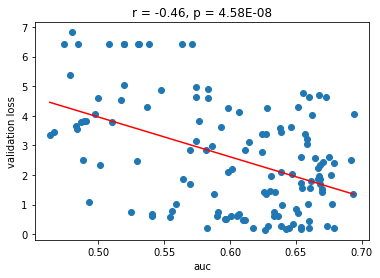

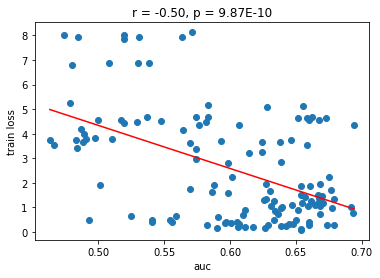

In [23]:
plot_correlation(bdd.auc, bdd.val_loss, xlabel='auc', ylabel='validation loss')
plt.show()
plot_correlation(bdd.auc, bdd.train_loss, xlabel='auc', ylabel='train loss')
plt.show()

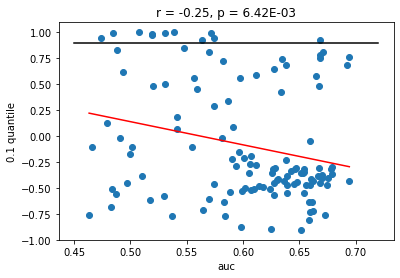

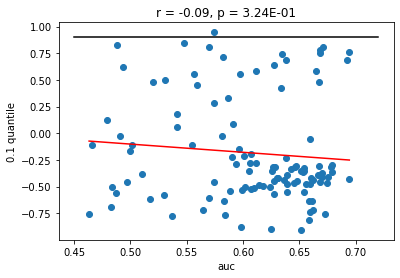

In [27]:
# 0.1 quantile and performance

filtered_bdd = bdd[~bdd['0.1_quantile'].isna()]


plot_correlation(filtered_bdd.auc, filtered_bdd['0.1_quantile'], xlabel='auc', ylabel='0.1 quantile')
plt.plot([0.45,0.72], [0.9, 0.9], color='black')
plt.show()

# same thing without the excluded ones
filtered_bdd = clean_bdd[~clean_bdd['0.1_quantile'].isna()]

plot_correlation(filtered_bdd.auc, filtered_bdd['0.1_quantile'], xlabel='auc', ylabel='0.1 quantile')
plt.plot([0.45,0.72], [0.9, 0.9], color='black')
plt.show()


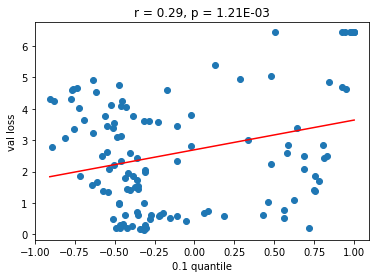

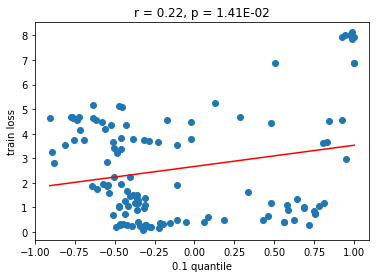

In [36]:
# 0.1 quantile and loss

filtered_bdd = bdd[~bdd['0.1_quantile'].isna()]

plot_correlation(filtered_bdd['0.1_quantile'], filtered_bdd.val_loss,  xlabel='0.1 quantile', ylabel='val loss')
plt.show()
plot_correlation(filtered_bdd['0.1_quantile'], filtered_bdd.train_loss,  xlabel='0.1 quantile', ylabel='train loss')
plt.show()

In [34]:
bdd.iloc[-10:,:]

,model_path,auc,auc_std,accuracy,accuracy_std,backbone_name,batch_size,drop_rate,early_stopping_patience,foldlabel,...,num_outputs,num_representation_features,temperature,temperature_initial,train_loss,val_loss,exclude,0.1_quantile,dataset_name,git_branch
45,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.488471,0.035180,0.548809,0.032750,convnet,16,0.15,100,False,...,4,4,0.1,0.1,3.643852,2.511922,False,0.831983,cingulate_HCP_1mm,Run_03_aymeric
128,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.486872,0.025558,0.577713,0.000000,pointnet,16,0.15,100,False,...,4,4,0.1,0.1,4.179968,3.784941,False,-0.562040,cingulate_HCP_half_1,pointnet
20,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.484643,0.042061,0.509701,0.048679,convnet,16,0.15,100,False,...,4,4,0.1,0.1,7.934572,6.433455,bad_learning,0.995956,cingulate_HCP_half_1,Run_03_aymeric
41,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.483937,0.027889,0.506886,0.025827,densenet,16,0.15,100,False,...,4,4,0.1,0.1,3.415136,3.560019,False,-0.506694,cingulate_HCP_half_1,Run_03_aymeric
39,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.482994,0.034076,0.512551,0.030729,densenet,16,0.15,100,False,...,4,4,0.1,0.1,3.753164,3.651408,False,-0.688383,cingulate_HCP_half_1,Run_03_aymeric
59,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.480352,0.022429,0.549314,0.014923,NaN,16,0.15,100,False,...,4,4,0.1,0.1,6.815775,6.824551,structure,NaN,cingulate_HCP_half_1,Run_43_joel
100,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.478818,0.022703,0.576880,0.003572,pointnet,16,0.05,100,True,...,4,4,0.5,0.5,5.256860,5.389712,False,0.129245,cingulate_HCP_half_1,pointnet
19,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.473885,0.042166,0.510393,0.050783,convnet,16,0.15,100,False,...,4,4,0.1,0.1,8.022524,6.433455,bad_learning,0.943119,cingulate_HCP_half_1,Run_03_aymeric
38,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.466274,0.034258,0.547683,0.020623,densenet,16,0.15,100,False,...,4,4,0.1,0.1,3.534628,3.446562,False,-0.106718,cingulate_HCP_half_1,Run_03_aymeric
129,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.463362,0.009882,0.559331,0.002454,pointnet,16,0.05,100,False,...,4,4,0.1,0.1,3.744332,3.345133,False,-0.757010,cingulate_HCP_half_1,pointnet


### Pointnet focus

In [67]:
pointnets = bdd[(bdd.backbone_name == 'pointnet')]
pointnets = pointnets[interesting_columns]
pointnets

,model_path,auc,auc_std,backbone_name,batch_size,dataset_name,drop_rate,foldlabel,num_representation_features,temperature
81,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.694205,0.008692,pointnet,16,cingulate_HCP_half_1,0.15,True,30,0.50
89,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.678702,0.006920,pointnet,16,cingulate_HCP_half_1,0.05,True,30,0.10
84,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.677713,0.000947,pointnet,16,cingulate_HCP_half_1,0.00,True,30,0.10
78,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.674897,0.015476,pointnet,16,cingulate_HCP_half_1,0.15,True,30,0.10
70,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.672935,0.013104,pointnet,16,cingulate_HCP_full,0.05,True,4,0.50
85,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.670079,0.008259,pointnet,16,cingulate_HCP_half_1,0.05,True,30,0.10
88,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.669777,0.006462,pointnet,16,cingulate_HCP_half_1,0.05,True,30,0.10
79,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.668236,0.018538,pointnet,16,cingulate_HCP_half_1,0.15,True,30,0.10
86,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.667489,0.007258,pointnet,16,cingulate_HCP_half_1,0.05,True,30,0.10
90,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.666463,0.007006,pointnet,16,cingulate_HCP_half_1,0.05,True,30,0.10


In [54]:
# consistency analysis
# take models with the same parameters and compare the performance

params = ['backbone_name', 'batch_size', 'drop_rate', 'early_stopping_patience',
        'foldlabel', 'input_size', 'lr', 'max_angle', 'max_epochs',
        'num_outputs', 'num_representation_features', 'numpy_all',
        'temperature', 'temperature_initial', 'git_branch']

df = bdd[params]

bdd[df.duplicated(keep=False) & (bdd.backbone_name == 'pointnet')]


,model_path,auc,auc_std,accuracy,accuracy_std,backbone_name,batch_size,drop_rate,early_stopping_patience,foldlabel,input_size,lr,max_angle,max_epochs,num_outputs,num_representation_features,numpy_all,temperature,temperature_initial,git_branch
71,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.694205,0.008692,0.669267,0.009264,pointnet,16,0.15,100,True,"(1, 17, 40, 38)",0.0004,6,250,30,30,/neurospin/dico/data/deep_folding/current/data...,0.5,0.5,pointnet
68,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.674897,0.015476,0.641771,0.015699,pointnet,16,0.15,100,True,"(1, 17, 40, 38)",0.0004,6,250,30,30,/neurospin/dico/data/deep_folding/current/data...,0.1,0.1,pointnet
69,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.668236,0.018538,0.655707,0.015699,pointnet,16,0.15,100,True,"(1, 17, 40, 38)",0.0004,6,250,30,30,/neurospin/dico/data/deep_folding/current/data...,0.1,0.1,pointnet
82,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.614146,0.015697,0.604997,0.017516,pointnet,16,0.15,100,False,"(1, 17, 40, 38)",0.0004,10,250,30,30,/neurospin/dico/data/deep_folding/current/data...,0.1,0.1,pointnet
72,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.606891,0.013846,0.607930,0.012928,pointnet,16,0.15,100,True,"(1, 17, 40, 38)",0.0004,6,250,30,30,/neurospin/dico/data/deep_folding/current/data...,0.5,0.5,pointnet
81,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.588038,0.032487,0.583425,0.027912,pointnet,16,0.15,100,False,"(1, 17, 40, 38)",0.0004,10,250,30,30,/neurospin/dico/data/deep_folding/current/data...,0.1,0.1,pointnet


In [76]:
bad_models = bdd[bdd.auc <= 0.55]

print("proportion 4 parmi les mauvais modèles :", bad_models[bad_models.num_representation_features == 4].shape[0]/bad_models.shape[0])
print("proportion 4 parmi les modèles :", bdd[bdd.num_representation_features == 4].shape[0]/bdd.shape[0])

bad_models

proportion 4 parmi les mauvais modèles : 0.7931034482758621
proportion 4 parmi les modèles : 0.3853211009174312


,model_path,auc,auc_std,accuracy,accuracy_std,backbone_name,batch_size,drop_rate,early_stopping_patience,foldlabel,...,max_angle,max_epochs,num_outputs,num_representation_features,temperature,temperature_initial,train_loss,val_loss,dataset_name,git_branch
27,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.547569,0.057362,0.539683,0.044184,densenet,16,0.15,100,True,...,6,250,4,4,0.1,0.1,4.531240,4.867878,cingulate_HCP_half_1,Run_03_aymeric
34,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.540923,0.033724,0.539085,0.029719,densenet,16,0.15,100,False,...,10,250,30,30,0.1,0.1,0.491312,0.603156,cingulate_HCP_half_1,Run_03_aymeric
30,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.538566,0.027027,0.577713,0.000000,densenet,16,0.15,100,True,...,6,250,4,4,0.1,0.1,6.863671,6.433455,cingulate_HCP_half_1,Run_03_aymeric
76,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.536983,0.005141,0.544880,0.003870,pointnet,16,0.05,100,True,...,6,250,4,4,0.5,0.5,4.673968,4.301939,cingulate_HCP_half_1,pointnet
8,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.530707,0.044796,0.506229,0.049234,convnet,16,0.15,250,True,...,6,250,4,4,0.1,0.1,7.934582,6.433455,cingulate_HCP_half_1,Run_03_aymeric
57,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.530619,0.044917,0.518217,0.051808,convnet,16,0.60,100,False,...,10,250,30,30,0.1,0.1,6.863864,6.437438,cingulate_HCP_half_1,Run_03_aymeric
21,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.529559,0.046242,0.530170,0.036701,convnet,16,0.15,250,False,...,10,250,4,4,0.1,0.1,4.490583,2.484959,cingulate_HCP_half_1,Run_03_aymeric
29,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.519898,0.052222,0.517889,0.044333,densenet,16,0.15,100,True,...,6,250,4,4,0.1,0.1,4.442244,5.053896,cingulate_HCP_half_1,Run_03_aymeric
18,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.519531,0.036233,0.508657,0.047433,convnet,16,0.15,100,False,...,10,250,4,4,0.1,0.1,8.032898,6.433870,cingulate_HCP_half_1,Run_03_aymeric
16,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.519293,0.042167,0.507683,0.046822,convnet,16,0.15,100,False,...,10,250,4,4,0.1,0.1,7.847290,6.433280,cingulate_HCP_half_1,Run_03_aymeric


### Compare full HCP and half HCP

In [84]:
# first batch

hcp_full = bdd[(bdd.dataset_name == 'cingulate_HCP_full') & (bdd.num_representation_features == 30)]
hcp_half = bdd[(bdd.dataset_name != 'cingulate_HCP_full') & (bdd.num_representation_features == 30) & (bdd.drop_rate == 0.05) & (bdd.foldlabel == True)]

print("Full:", hcp_full.auc.mean(), "Half:", hcp_half.auc.mean())

Full: 0.6439337281443881 Half: 0.6676759259259258


In [85]:
# second batch

hcp_full = bdd[(bdd.dataset_name == 'cingulate_HCP_full') & (bdd.num_representation_features == 4)]
hcp_half = bdd[(bdd.dataset_name != 'cingulate_HCP_full') & (bdd.num_representation_features == 4) & (bdd.drop_rate == 0.05) & (bdd.foldlabel == True)]

print("Full:", hcp_full.auc.mean(), "Half:", hcp_half.auc.mean())

Full: 0.5866613931190072 Half: 0.5914255499153975


Full HCP isn't worth it